# Q-Learning for a gridworld - ACDC2020


# Set working directory

In [4]:
working_dir = '/content/drive/My Drive/Colab Notebooks/QLearning_for_gridworld'
%cd $working_dir
# sys.path.append(working_dir)

/content/drive/My Drive/Colab Notebooks/QLearning_for_gridworld


## Import required pachages:

In [5]:
import os
import sys
import gym
import random
import numpy as np

In [6]:
from gridworld_environment import Environment
from agents import QAgent
import visutils

### Define a helper function for visualization

In [7]:
import time
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [9]:
### This render function is for visualizing the agent performance in the notebook. 
### If you run the training in a Python IDE like Spyder, PyCharm or VS Code, you do not need this funciton; instead you can just use env.render() methode. 
### However, for some reasons env.render() methode does not work in notebook. That's why I defined the render function again.
def rendering(t, env, cur_state, new_state):
    pltdata = env.view
    if t == 1:
        pltdata.fig, pltdata.ax = plt.subplots(figsize=(5,5))
        plt.xticks([])
        plt.yticks([])
        c = pltdata.ax.pcolor(pltdata.chessboard, edgecolors='k', linewidths=3, cmap='binary')

        for p in range(pltdata.bsize):
          pltdata.ax.text(pltdata.tp2cl(p)[1]+0.55, pltdata.tp2cl(p)[0]+0.55, str(p), fontsize=12)

        pltdata.ax.text(pltdata.p2c(pltdata.start_state)[1]+0.32, pltdata.p2c(pltdata.start_state)[0]+0.32, 'S', fontsize=28, color='red', fontweight='bold')
        pltdata.ax.text(pltdata.p2c(pltdata.goal_state)[1]+0.32, pltdata.p2c(pltdata.goal_state)[0]+0.32, 'G', fontsize=28, color='green', fontweight='bold')

        for t in range(pltdata.n_blocked_cells):    
            rect_xy = pltdata.wall_cell_coords[t]
            COLOR = pltdata.EVEN_COLOR if t % 2 == 0 else pltdata.ODD_COLOR 
            rect = patches.Rectangle((rect_xy[1]+pltdata.rect_shift_x, rect_xy[0]+pltdata.rect_shift_y), pltdata.rect_w, pltdata.rect_h, linewidth=1, edgecolor='r', facecolor=COLOR)
            pltdata.ax.add_patch(rect)

    
    arrow_start = np.array(pltdata.tp2cl(cur_state)) + 0.5
    arrow_stop = np.array(pltdata.tp2cl(new_state)) + 0.5
    diff = (arrow_stop[0] - arrow_start[0], arrow_stop[1] - arrow_start[1])
    COLOR = (np.random.rand(), np.random.rand(), np.random.rand())
    if not np.array_equal(arrow_start, arrow_stop):
        pltdata.ax.arrow(arrow_start[1], arrow_start[0], diff[1], diff[0], head_width=0.2, head_length=0.2, fc=COLOR, ec=COLOR)

    time.sleep(0.5)
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Instantiate the environment

In [10]:
## There are two pre-defined puzzles inside the MdpMetaData class: a 5*5 and a 10*10 maze. Here we instantiate the Environment class with a 5*5 maze
env = Environment(default=5)

### Instantiate the agent

In [11]:
agent = QAgent(env) 

## Train Q-Learning Agent

In [12]:
def train_AQgent(env, agent, n_episodes=2400, render=True):
  total_reward = []
  view_freq = 500
  obs_history = {ep:[] for ep in range(n_episodes)}
  for ep in range(n_episodes):
      if ep % view_freq == 0:
          print('---------- The episode number is: ', ep)
      episode_reward = []
      state = env.reset()
      done = False
      t = 0
      while not done:
          t += 1
          obs_history[ep].append(state)
          action = agent.get_action(state)
          next_state, reward, done, info = env.step(action)
          experience = (state, action, next_state, reward, done)
          agent.train(experience)
          episode_reward.append(reward)        
          
          # experience_list = list(experience)
          # for str_a, int_a in env.actions.items():  
          #     if action == int_a:
          #         experience_list[1] = str_a
          # print('Experience: ', experience_list)
          
          if render:
            print("comment the following 3 lines to prevernt visualiztion and decrease the computation time")
            if ep in [1000, 2000]:
              print(f'The agent navigation in episode {ep}:')
              rendering(t, env, state, next_state) 

          state = next_state
          
          if done:
              if ep % view_freq == 0:
                  print("Episode finished after {} timesteps".format(t))
                  print("Current epsilon is: ", agent.epsilon)
                  print('Episode Reward: {}'.format(np.sum(episode_reward)))
              break
      total_reward.append(np.sum(episode_reward))
  return env, agent, total_reward, obs_history

In [13]:
env, agent, total_reward, obs_history = train_AQgent(env, agent, n_episodes=2400, render=False)

---------- The episode number is:  0
Episode finished after 62 timesteps
Current epsilon is:  0.9998
Episode Reward: -61
---------- The episode number is:  500
Episode finished after 45 timesteps
Current epsilon is:  0.9046474028267117
Episode Reward: -44
---------- The episode number is:  1000
Episode finished after 96 timesteps
Current epsilon is:  0.8185506335678283
Episode Reward: -95
---------- The episode number is:  1500
Episode finished after 46 timesteps
Current epsilon is:  0.7406478343061563
Episode Reward: -45
---------- The episode number is:  2000
Episode finished after 49 timesteps
Current epsilon is:  0.6701591715486028
Episode Reward: -48


#### Plot the total reward per episode 

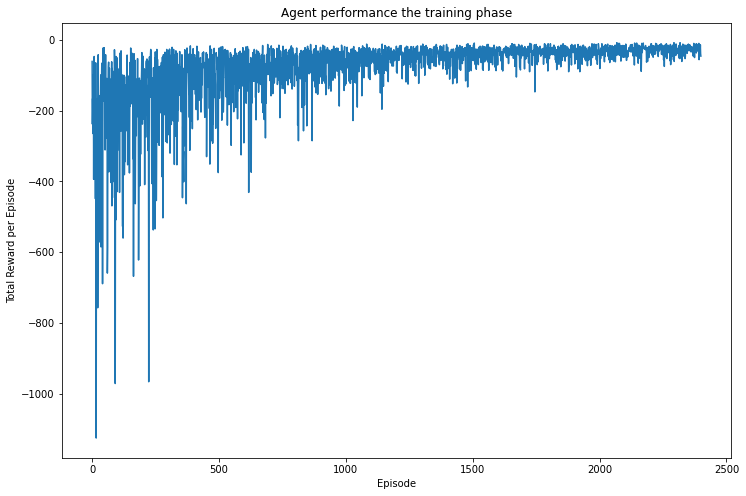

In [14]:
visutils.plot_reward(total_reward)

#### Check the agent performance in some episodes:

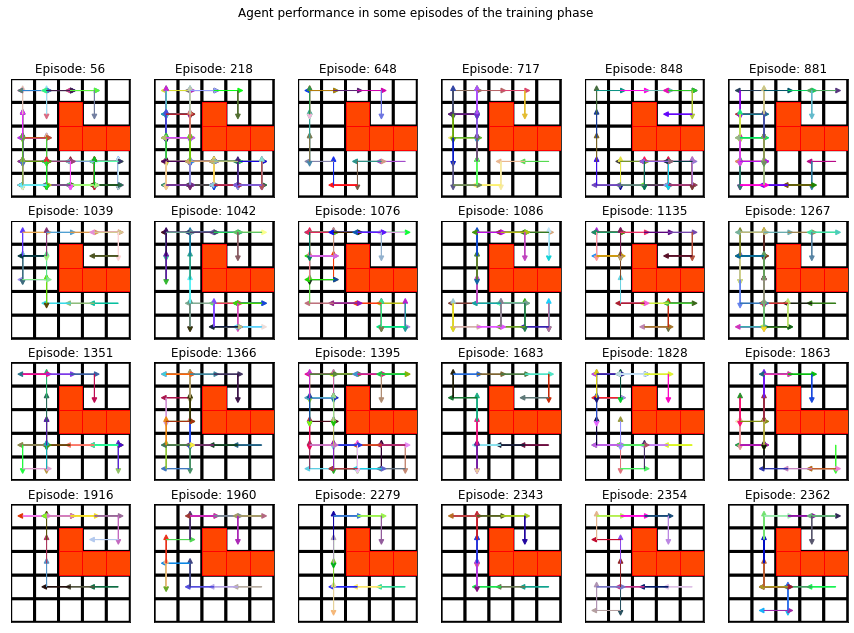

In [15]:
visutils.plot_obs_history(env, obs_history)

## Test Q-Learning Agent

In [16]:
q_table = agent.q_table

In [17]:
def test_QAgent(env, agent, n_episodes, render=True):
  q_table = agent.q_table
  total_reward = []
  for ep in range(n_episodes):
      print('========================================')
      print('---------- The episode number is: ', ep)
      episode_reward = []
      state = env.reset()
      done = False
      t = 0
      while not done:
          t += 1
          action = np.argmax(q_table[state])
          next_state, reward, done, info = env.step(action)
          experience = (state, action, next_state, reward, done)
          # print('Experience: ', experience)
          episode_reward.append(reward)        

          agent.train(experience)

          if render:
            rendering(t, env, state, next_state)
          
          state = next_state

          if done:
              print("Episode finished after {} timesteps".format(t))
              break

      total_reward.append(np.sum(episode_reward))
      print('Episode Reward: {}'.format(np.sum(episode_reward)))

Episode finished after 9 timesteps
Episode Reward: -8


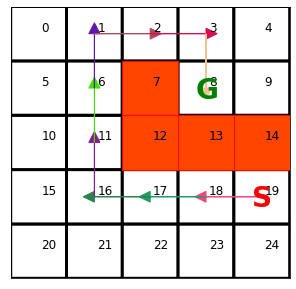

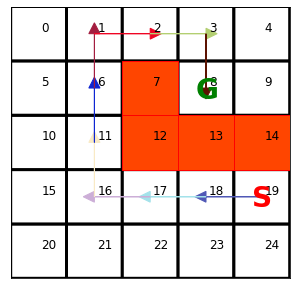

In [18]:
test_QAgent(env, agent, n_episodes=1, render=True)